In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import json
from itertools import product

from keras.models import Sequential, load_model
from keras.layers import *

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback

import matplotlib.pyplot as plt
plt.style.use('seaborn')

Using TensorFlow backend.


# Summary
I'm fitting the keras' embedding layer for a few epochs within the possibly simplest imaginable setup, namely with global averaging and softmax on top. This examinations in meant to be fairly inexpensive but broad, and serve to produce reasonable starting embeddings for more complicated net architectures and to compare various loss-functions/batch-sizes/optimizers. The choice of loss function is a somewhat non-trivial matter due to the class imbalance of our dataset and the stated objective of maximazing the macroF1 score.

* Results land in the directory defined in the *working_dir* variable below.
* Weights are stores as *blabla_weights.p* and they may be directly depickled into the *weights* argument of the Embedding layer (see the *Embedding* within *init* of the *BlackBox* class). 
* There are some nice plots below.

We manage to establish an interesting benchmark for our dataset: the simple setup described above is almost enough to reproduce the perfomarmance of shallow classifiers, *macroF1*=80%. For other net architectures to carry their weight, they'll have to go beyond that.

---

### Load the data in
The test data is not used

In [2]:
global_params = pickle.load(open("global_params.p", "rb"))
unique_words = global_params['unique_words']
num_words = global_params['num_words']
padded_length = global_params['padded_length']
n_classes = global_params['n_classes']
class_weights = global_params['class_weights']

global_params

{'unique_words': 277303,
 'num_words': 277304,
 'padded_length': 679,
 'n_classes': 6,
 'class_weights': array([ 1.26825655,  0.72736371,  0.27602776, 13.23801959, 30.29201502,
         9.49559404])}

In [3]:
X_train = np.load(os.path.join("data", "Kdata", "X_train.npy"))
y_train = np.load(os.path.join("data", "Kdata", "y_train.npy"))
X_val = np.load(os.path.join("data", "Kdata", "X_val.npy"))
y_val = np.load(os.path.join("data", "Kdata", "y_val.npy"))

---

## Start of boilerplate

### Some custom definitions
* metrics
* loss functions
* learning hyper-parameters and settings

In [4]:
from keras import backend as K

# Custom metrics.
# Note that any metric is computed per batch during training
# (hence one needs large batches for it to make sense).
# Also, there is the implicit 0.5 treshold in the K.round function below

def macroPrec(y_true, y_pred):
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    positives = K.sum(K.round(y_pred), axis=0)
    precision = true_positives / (positives + K.epsilon())

    macroPrec = K.mean( precision )
    
    return macroPrec


def macroRecall(y_true, y_pred):
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    actual_ones = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    macroRecall = K.mean( recall )
    
    return macroRecall


def macroF1(y_true, y_pred):

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    
    actual_ones = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=0)
    precision = true_positives / (positives + K.epsilon())
    
    macroF1 = 2 * K.mean( precision*recall / (precision + recall + K.epsilon()) )
    
    return macroF1



# Custom loss functions
# No clippping or rounding as those are not differentiable
# Note to self: these functions are already taking into account class imbalances, so remeber
# not to set the class_weight argument in fitting method when using them as the loss 

# semi macroF1
def fuzzy_macroF1_flip(y_true, y_pred):

    true_positives = K.sum(y_true * y_pred, axis=0)
    
    actual_ones = K.sum(y_true, axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    positives = K.sum(y_pred, axis=0)
    precision = true_positives / (positives + K.epsilon())
    
    macroF1 = 2 * K.mean( precision*recall / (precision + recall + K.epsilon()) ) 
    
    return 1-macroF1


# weighted categorical crossentropy
def my_crossE(y_true, y_pred):
    
    class_entropy = K.sum(y_true * K.log(y_pred+K.epsilon()), axis=0)
    weighted_entropy = K.mean(class_weights * class_entropy)
    return -4E-4 * weighted_entropy  # arbitrary coefficient to make it close to [0-1] interval


# take average of the last two, because why not
def my_loss(y_true, y_pred):
    # return 0.5*(fuzzy_macroF1_flip(y_true, y_pred) + my_crossE(y_true, y_pred))
    
    true_positives = K.sum(y_true * y_pred, axis=0)
    
    actual_ones = K.sum(y_true, axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    positives = K.sum(y_pred, axis=0)
    precision = true_positives / (positives + K.epsilon())
    
    macroF1p2 = K.mean( precision*recall / (precision + recall + K.epsilon()) )
    
    class_entropy = K.sum(y_true * K.log(y_pred+K.epsilon()), axis=0)
    weighted_entropy = K.mean(class_weights * class_entropy)
    
    return 0.5 - macroF1p2 - 2E-4 * weighted_entropy

In [5]:
my_metrics = [macroPrec, macroF1, macroRecall] #, my_crossE, fuzzy_macroF1_flip, my_loss]

custom_objects={'macroPrec': macroPrec,\
                'macroF1': macroF1,\
                'macroRecall': macroRecall,\
                'my_crossE': my_crossE,\
                'fuzzy_macroF1_flip': fuzzy_macroF1_flip,\
                'my_loss': my_loss
               }

In [6]:
# auxiliary function
# to plot the learning history,
# i.e. loss and metrics on each train_batch and validation_batch
def plot_history(history, with_lr=False):
    
    n_plots = 3 if with_lr else 2
    plt.figure(figsize=(6*n_plots, 5))
    
    loss = history['loss']
    val_loss = history['val_loss']
    x = range(1, len(loss) + 1)
    
    plt.subplot(1, n_plots, 1)    
    plt.plot(x, loss, 'ob', label='Training loss')
    plt.plot(x, val_loss, '-b', label='Validation loss')
    plt.title('Training and val losses') 
    plt.legend()
    
    all_metrics = np.array(list(set(history.keys()) - set(['loss', 'val_loss', 'lr'])))
    metrics = all_metrics[[not metric.startswith('val_') for metric in all_metrics]]
    plt.subplot(1, n_plots, 2)
    markers = ['b', 'r',  'g', 'y', 'm', 'c', 'k']
    marker = zip(markers, markers)
    for metric in metrics:
        results = history[metric]
        val_results = history['val_'+metric]
        mark1, mark2 = next(marker)
        plt.plot(x, results, 'o'+mark1, label=metric)
        plt.plot(x, val_results, '-'+mark2, label='Validation '+metric)
        plt.title('Training and val metrics')
    plt.legend()
    
    if with_lr:
        plt.subplot(1, 3, 3)
        lr = history['lr'] # learning rate
        plt.plot(x, lr, 'k', label='Learning rate')
        plt.title('Learning rate')  
        plt.legend()
    

### Define a wrapper class for creating the classification model with embedding, fitting, etc.
It creates an useful object using a list of intermediate layers as the main argument.
Makes it easier to consistently use the chosen metrics, loss function, class_weights, embedding etc.

In [1]:
working_dir = "keras_simpleGS_results"
! mkdir keras_simpleGS_results

In [8]:
# the workhorse
class BlackBox():
    
    def __init__(self, layers, loss, batch_size, optimizer, epochs,\
                 metrics=my_metrics,\
                 verbose=0,\
                 callbacks=None,\
                 embedd = None, embedd_dims=[None]*3, train_weights=True,\
                 mask_zeros=True
                ):
        
        self.layers = layers
        self.loss = loss
        self.loss_name = self.loss.__name__ if self.loss != 'categorical_crossentropy' else 'cat-cross'
        self.batch_size = batch_size
        self.epochs = epochs
        self.optimizer = optimizer
        self.metrics = metrics
        self.verbose = verbose
        self.callbacks = callbacks
        if loss == 'categorical_crossentropy':
            self.class_weight = class_weights
        else:
            self.class_weight = None
        self.train_weigts = train_weights
        self.mask_zeros = mask_zeros
        
        self.history = None
        self.test_results = None
        self.val_score = None
                
        self.model = Sequential()
        if embedd:
            self.input_dim = embedd_dims[0] # num_words
            self.output_dim = embedd_dims[1] # dimension of the embedding space
            self.input_length = embedd_dims[2] # padded_length
            with open(embedd, "rb") as f:
                self.embedd_weights = pickle.load(f)
            
            self.model.add(Embedding(input_dim=self.input_dim,\
                                     output_dim=self.output_dim,\
                                     input_length=self.input_length,\
                                     weights=self.embedd_weights,\
                                     trainable=self.train_weigts,\
                                     mask_zero=self.mask_zeros))
            self.model.layers[0].trainable = self.train_weigts  # szczeżonego panbug szczeże
            
        for layer in layers:
            self.model.add(layer)
            
        self.model.add(Dense(n_classes, activation='softmax'))
        self.model.compile(loss=self.loss, optimizer=self.optimizer, metrics=self.metrics)
        
        self.name = f"{self.loss_name}_batch{self.batch_size}_{self.optimizer}"
        self.describe = f"loss={self.loss_name}, batch_size={self.batch_size}, optimizer={self.optimizer}, explicit-class-weights: {type(self.class_weight)==np.ndarray}, embedd-trainable: {self.model.layers[0].trainable}"

    
    def summary(self):
        print(self.describe)
        return self.model.summary()
    
    def fit(self):
        print(self.describe)
              
        self.history = self.model.fit(
            X_train, y_train,
            class_weight=self.class_weight,
            epochs=self.epochs,
            batch_size=self.batch_size,
            #validation_split=0.1,
            validation_data=(X_val, y_val),
            callbacks=self.callbacks,
            verbose = self.verbose        
            ).history
        self.val_score = self.history['val_macroF1'][-1]
        print(f"Last val_macroF1: {self.val_score}")

        
    def evaluate(self, X_test, y_test):
        
        print(f'Loss function: {self.loss_name}. Metrics: {[metric.__name__ if callable(metric) else metric for metric in self.metrics]}')
        print("Predicting for X_test, comparing with y_test")
        return self.model.evaluate(X_test, y_test)
    
    def plot(self, with_lr=False, from_file=False):
        print(self.describe)
        try:
            if not from_file:
                plot_history(self.history, with_lr=with_lr)
            else:
                hist = json.load(open(os.path.join(working_dir, f"{self.name}_history.p"), "r"))
                plot_history(hist, with_lr=with_lr)
        except:
            print("nope!")
        
    def save_embedd(self):
        file = os.path.join(working_dir, f"{self.name}_weights.p")
        with open(file, 'wb') as f:
            pickle.dump(self.model.layers[0].get_weights(), f)
        
    def Ksave(self):
        file = os.path.join(working_dir, f"{self.name}_Kmodel.h5")
        self.model.save(file)
        
    def discard(self):
        self.model = None
    
    def save_hist(self):
        file = os.path.join(working_dir, f"{self.name}_history.p")
        with open(file, 'w') as f:
            json.dump(self.history, f)


In [9]:
# # choose callbacks to be given in model.fit(...)


# # If the embedding layer is given to BlackBox from a file
# # and it is set to not be trainable,
# # it may yet be unfrozen by a callback piggybacking on the ReducLROnPlateau callback

# class WakeEmbedding(Callback):
    
#     def __init__(self, rel_lr_treshold):
#         self.rel_lr_treshold = rel_lr_treshold
    
#     def on_train_begin(self, logs={}):
#         self.init_lr =  K.eval(self.model.optimizer.lr)
        
#     def on_epoch_begin(self, epoch, logs={}):
#         lr =  K.eval(self.model.optimizer.lr)
#         if (lr / self.init_lr) <= self.rel_lr_treshold:
#             self.model.layers[0].trainable = True
#         print("Embedding trainable:", self.model.layers[0].trainable)

        
# # the early-stopping is monitoring the batchwise-macroF1 (which is risky)

# def callbacks(plateau_factor=0.1, plateau_patience=1,\
#               early_s_patience = 2,\
#               wake_embedd=False, wake_treshold = 0.1
#              ):
    
#     callbacks = [ReduceLROnPlateau(factor=plateau_factor,\
#                                    monitor='val_macroF1', mode='max', patience = plateau_patience),
#                 EarlyStopping(monitor='val_macroF1', mode='max', patience=early_s_patience)
#                ]
    
#     return callbacks + [WakeEmbedding(wake_treshold)] if wake_embedd else callbacks


## End of boilerplate

---
---

# Quasi-grid-search that optimizes the BlackBox
* Define the sequential setup by specifiying the layers, and parameter scopes to search through.
* Train for a fixed number of epochs.
* Examine how different parameter combinations influence quality of the classification (measured by the resulting model's macro-F1 on the validation set).

---

In [10]:
# the setup

layers = [Embedding(input_dim=num_words, output_dim=50, input_length=padded_length, mask_zero=True),
          Dropout(0.5),
          GlobalAveragePooling1D()
         ]

In [13]:
# the options

losses = [my_loss, 'categorical_crossentropy']
batch_sizes = [500, 800, 1000]
optimizers = ['adam', 'nadam']

options = list(product(losses, batch_sizes, optimizers))
n_options = len(options)
print(f"{n_options} options in the cross-search, e.g. {options[0]}")

12 options in the cross-search, e.g. (<function my_loss at 0x7f4d29db61e0>, 500, 'adam')


In [16]:
# fit and validate for the epochs, loop through the options

epochs = 2
results = {}

def run_test(k):

    loss, batch_size, optimizer = options[k]
    print(f"\n{k+1}/{n_options}")    

    model = BlackBox(layers=layers, loss=loss, batch_size=batch_size, optimizer=optimizer, epochs=epochs, verbose=1)
    model.fit()
    model.discard()
     
    results[k] = model

    
for k in range(n_options):
    run_test(k)


1/12
loss=my_loss, batch_size=500, optimizer=adam, explicit-class-weights: False, embedd-trainable: True
Train on 500000 samples, validate on 200000 samples
Epoch 1/2
500000/500000 [==============================] - 736s 1ms/step - loss: 0.3257 - macroPrec: 0.4501 - macroF1: 0.3849 - macroRecall: 0.3620 - val_loss: 0.2205 - val_macroPrec: 0.7746 - val_macroF1: 0.6613 - val_macroRecall: 0.6200
Epoch 2/2
500000/500000 [==============================] - 718s 1ms/step - loss: 0.1737 - macroPrec: 0.7841 - macroF1: 0.7364 - macroRecall: 0.7218 - val_loss: 0.1554 - val_macroPrec: 0.7747 - val_macroF1: 0.7500 - val_macroRecall: 0.7491
Last val_macroF1: 0.7500360867381096

2/12
loss=my_loss, batch_size=500, optimizer=nadam, explicit-class-weights: False, embedd-trainable: True
Train on 500000 samples, validate on 200000 samples
Epoch 1/2
500000/500000 [==============================] - 780s 2ms/step - loss: 0.2078 - macroPrec: 0.7081 - macroF1: 0.6522 - macroRecall: 0.6359 - val_loss: 0.1471 -

In [17]:
# display results ordered by the macro-F1 on validation set obtained after the second epoch

results_list = [(k+1, model.val_score, model.loss_name, model.batch_size, model.optimizer) for (k, model) in results.items()]
ranking_list = sorted(results_list, key=lambda item: item[1], reverse = True)
ranking_list

[(6, 0.7876001408696175, 'my_loss', 1000, 'nadam'),
 (4, 0.7857791392803192, 'my_loss', 800, 'nadam'),
 (5, 0.7814671802520752, 'my_loss', 1000, 'adam'),
 (3, 0.7740461661815643, 'my_loss', 800, 'adam'),
 (2, 0.7735363245010376, 'my_loss', 500, 'nadam'),
 (12, 0.7674658605456353, 'cat-cross', 1000, 'nadam'),
 (10, 0.7640703551769257, 'cat-cross', 800, 'nadam'),
 (8, 0.7585610404610634, 'cat-cross', 500, 'nadam'),
 (9, 0.7505354590415955, 'cat-cross', 800, 'adam'),
 (1, 0.7500360867381096, 'my_loss', 500, 'adam'),
 (7, 0.7411315003037453, 'cat-cross', 500, 'adam'),
 (11, 0.7233834239840508, 'cat-cross', 1000, 'adam')]

### Commentary
The differences are marginal. They are also subject to statistical fluctuations due to shuffling of the data done by keras. Seeing as our simple neural network is not necessarilly very representative of more complicated nets it is not guaranteed that the winner of our search will always be best. Nonetheless the above results tell a fairly consistent story in the context of our data. **my_loss** is better than **cat-cross**. **nadam** is better than **adam**. And, in the range of the order of few hundreds, the bigger the batch_size the better but the gain from that is the least significant and **batch_size=800** seems good enough. 


---

### Longer fit of the two loss functions
Let's settle on *optimizer*=nadam, *batch_size*=800, and compare the results obtained on a stretch of a few more epochs. 

loss=my_loss, batch_size=800, optimizer=nadam, explicit-class-weights: False, embedd-trainable: True
Train on 500000 samples, validate on 200000 samples
Epoch 1/8
500000/500000 [==============================] - 620s 1ms/step - loss: 0.2918 - macroPrec: 0.5758 - macroF1: 0.4989 - macroRecall: 0.4706 - val_loss: 0.1745 - val_macroPrec: 0.7826 - val_macroF1: 0.7478 - val_macroRecall: 0.7342
Epoch 2/8
500000/500000 [==============================] - 613s 1ms/step - loss: 0.1485 - macroPrec: 0.7922 - macroF1: 0.7797 - macroRecall: 0.7845 - val_loss: 0.1430 - val_macroPrec: 0.7791 - val_macroF1: 0.7782 - val_macroRecall: 0.7939
Epoch 3/8
500000/500000 [==============================] - 609s 1ms/step - loss: 0.1254 - macroPrec: 0.8059 - macroF1: 0.8091 - macroRecall: 0.8270 - val_loss: 0.1354 - val_macroPrec: 0.7895 - val_macroF1: 0.7859 - val_macroRecall: 0.7980
Epoch 4/8
500000/500000 [==============================] - 610s 1ms/step - loss: 0.1134 - macroPrec: 0.8202 - macroF1: 0.8271 - ma

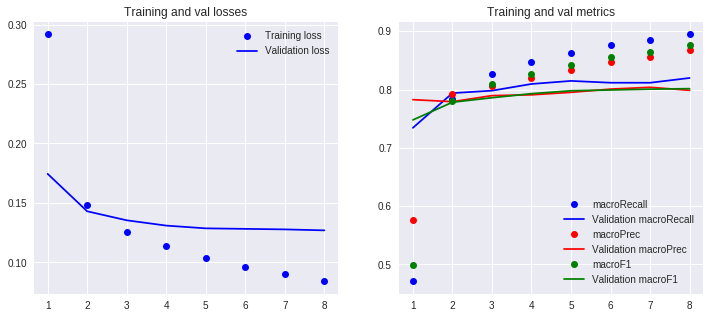

In [11]:
loss, batch_size, optimizer = my_loss, 800, 'nadam'

model = BlackBox(layers=layers, loss=loss, batch_size=batch_size, optimizer=optimizer, epochs=8, verbose=1)
model.fit()
model.save_embedd()
model.Ksave()
model.save_hist()
model.discard()
model.plot()

loss=cat-cross, batch_size=800, optimizer=nadam, explicit-class-weights: True, embedd-trainable: True
Train on 500000 samples, validate on 200000 samples
Epoch 1/8
500000/500000 [==============================] - 610s 1ms/step - loss: 0.4548 - macroPrec: 0.4740 - macroF1: 0.3952 - macroRecall: 0.3746 - val_loss: 0.2288 - val_macroPrec: 0.7689 - val_macroF1: 0.5586 - val_macroRecall: 0.5172
Epoch 2/8
500000/500000 [==============================] - 610s 1ms/step - loss: 0.1934 - macroPrec: 0.8599 - macroF1: 0.7022 - macroRecall: 0.6446 - val_loss: 0.1955 - val_macroPrec: 0.8464 - val_macroF1: 0.7381 - val_macroRecall: 0.6866
Epoch 3/8
500000/500000 [==============================] - 610s 1ms/step - loss: 0.1700 - macroPrec: 0.8783 - macroF1: 0.7985 - macroRecall: 0.7558 - val_loss: 0.1875 - val_macroPrec: 0.8411 - val_macroF1: 0.7660 - val_macroRecall: 0.7269
Epoch 4/8
500000/500000 [==============================] - 610s 1ms/step - loss: 0.1590 - macroPrec: 0.8858 - macroF1: 0.8257 - m

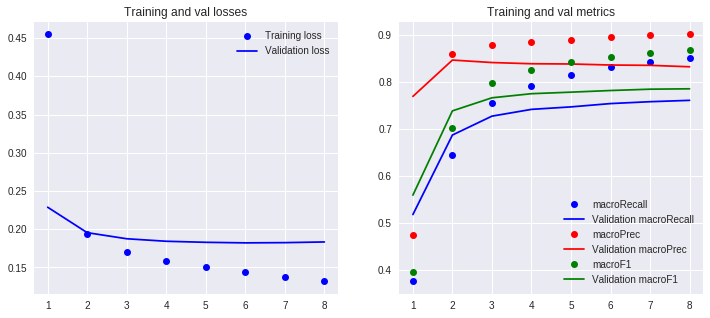

In [12]:
loss, batch_size, optimizer = 'categorical_crossentropy', 800, 'nadam'

model2 = BlackBox(layers=layers, loss=loss, batch_size=batch_size, optimizer=optimizer, epochs=8, verbose=1)
model2.fit()
model2.save_embedd()
model2.Ksave()
model2.save_hist()
model2.discard()
model2.plot()

### Commentary
* Looking at the validation scores: The *my_loss* function is better than *categorical crossentropy* at keeping the precision and recall equal. It actually emphasizes the recall more, so that - after 3rd epoch - it scores slightly better than precision. The *cat-cross* on the other hand is able to quickly launch the precision beyond 84%, but the recall is not able to keep up and it then pulls the precision down at later epochs.

* Starting from the 3rd epoch we see overfitting: the scores obtained directly on train-data are higher. Interestingly, here the cross-entropy seems more promising than on the validation set: it is able to overfit the recall without sacrificing the precision. Still, what matters is the validation score.

* Recall that our final macro-F1 on test data reached by the SVM was 80%. Here we do not want to look at the test data just yet, but it seems that we have reproduced the result of a shallow classifier with a 50-dimensional embedding, global averaging, and a single softmax-layer.

---


### End